In [41]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
from datasets import Dataset, DatasetDict
from sentence_transformers import SentenceTransformer, util
import datasets

%matplotlib inline

PREPROCESS = False
AUGMENT = False
# leadboard: https://www.sbert.net/docs/pretrained_models.html#model-overview
# following model is not the best, but good tradeoff between speed and accuracy
model_for_embeddings = "all-MiniLM-L6-v2"

DATA_SAVE_NAME = "final_ann_data"
if PREPROCESS:
    DATA_SAVE_NAME = "preprocess_final_ann_data"

In [42]:
sns.set_style("darkgrid")
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [43]:
data = pd.read_csv("../data/data.csv")

In [44]:
data.head()

,Customer,Type,Text,Summary
0,Notion,Appstore/Playstore,User: The app doesn't send sound or vibration ...,User finds the app useless without sound or vi...
1,Notion,Appstore/Playstore,"User: This app changed my life, I can only say...","User praises the app, stating it has changed t..."
2,Notion,Appstore/Playstore,User: Have you ever experienced this situation...,NaN
3,Notion,Appstore/Playstore,User: Mass editing a table/database is so slow...,User finds Notion's mass editing feature slow ...
4,Notion,Appstore/Playstore,User: the only concern is that it doesn't work...,User is concerned about the product not workin...


In [152]:
data.shape

(5009, 4)

Text(0.5, 1.0, 'Number of samples of each Customer')

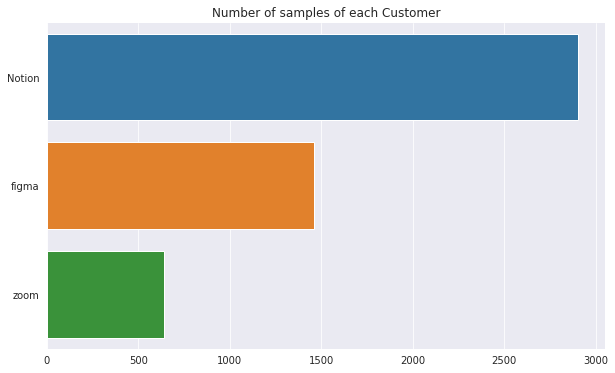

In [59]:
sns.barplot(data = data, x = list(data['Customer'].value_counts().values), y = list(data['Customer'].value_counts().index))
plt.title("Number of samples of each Customer")

Text(0.5, 1.0, 'Number of samples of each Type')

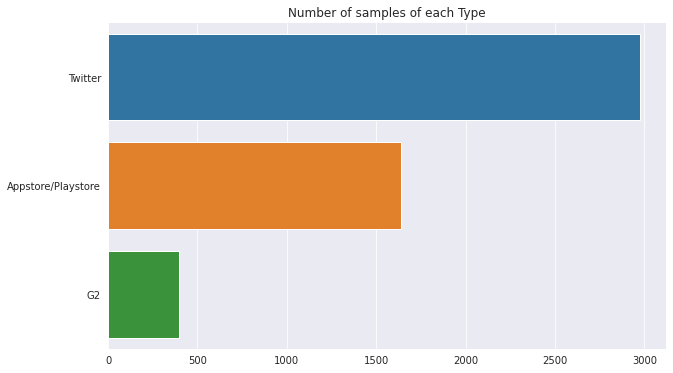

In [60]:
sns.barplot(data = data, x = list(data['Type'].value_counts().values), y = list(data['Type'].value_counts().index))
plt.title("Number of samples of each Type")

In [153]:
data.isna().sum()

Customer       0
Type           0
Text           0
Summary     1008
dtype: int64

In [154]:
print(data[data['Summary'].isna()]['Summary'])

2       NaN
8       NaN
15      NaN
17      NaN
18      NaN
       ... 
5004    NaN
5005    NaN
5006    NaN
5007    NaN
5008    NaN
Name: Summary, Length: 1008, dtype: object


In [45]:
# we want even such samples in training. So replace Summary with "None"
data['Summary'].fillna("Nothing", inplace = True)
data['Summary'] = data['Summary'].apply(lambda text: text.strip())
data['Text'] = data['Text'].apply(lambda text: text.strip())

# replace `\n None` with `None`
data['Summary'] = data['Summary'].replace("\n None", "Nothing")
data["Summary"] = data["Summary"].replace("\n\n\nNone", "Nothing")
data["Summary"] = data['Summary'].apply(lambda text: "Nothing" if text in ["\n", "none", "\nNone", "\nnone"] else text)

In [46]:
data.isna().sum()

Customer    0
Type        0
Text        0
Summary     0
dtype: int64

In [47]:
data['text_length'] = data['Text'].apply(lambda text: len(text.split()))
data['summary_length'] = data['Summary'].apply(lambda summary: len(summary.split()))
data['sum_text_ratio'] = data['summary_length'] / data['text_length']

Text(0.5, 1.0, 'Ratio of summary to text length')

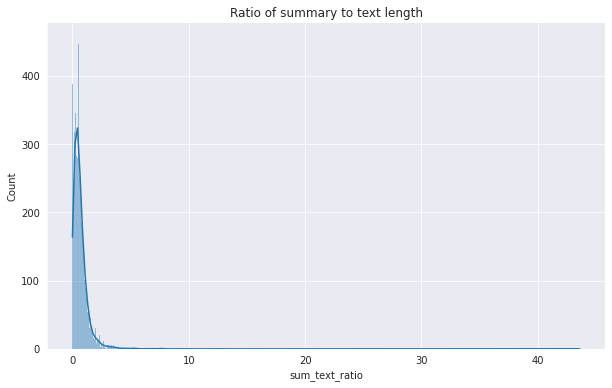

In [51]:
# some summaries are larger than the text
sns.histplot(data['sum_text_ratio'], kde = True)
plt.title("Ratio of summary to text length")

Text(0.5, 1.0, 'Ratio of summary to text length')

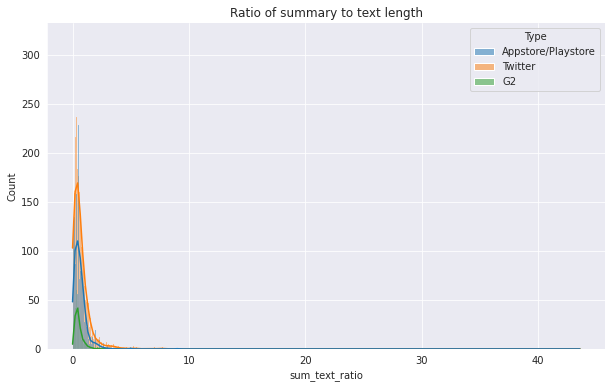

In [49]:
# Twitter has more samples with higher summary to text length ratio
sns.histplot(data = data, x = 'sum_text_ratio', kde = True, hue = "Type")
plt.title("Ratio of summary to text length wrt Type")

In [159]:
# such Twittter texts will be almost impossible to summarize 
print("Original Text: ", data[data['sum_text_ratio'] > 10].reset_index(drop = True)['Text'][0])
print("Summary: ", data[data['sum_text_ratio'] > 10].reset_index(drop = True)['Summary'][0])

Original Text:  User: Pretty! 💙
@browsercompany <STRICT_LINK>
Summary:  User: I'm not sure if I'm the only one who's having this issue, but I'm having a problem with the browserco app. I can't get it to open. I've tried restarting my phone, restarting the app, and even restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app 

In [160]:
# Some examples: 

# // Need to extract only summary from such examples. 
# // Summary is irrelevant to the Text
# Text: User: Where is the Arabic language thanks 
# Summary:  
# Product: Notion
# Feedbacktype: RecordTypeReview
# Review Content: User: I love it
# Summary: User loves the product.

# // Summary is irrelevant to the Text
# Text: User: Spanish - Spanish
# Summary: 
# Review Content: User: I love it
# Summary:
# User loves the product.

# Text: User: 123
# Summary:
# Review Content: User: 123
# Summary:
#  None

# // Different language
# Text: User: iPhoneとiPadだと日本語でタイトル入力すると消える！
# Summary: User experiences issues with the app on iPhone and iPad, where the title input disappears when using Japanese.

# // Twitter content that cant be inferred without strict link
# Text: User: This week's @NotionHQ content is brought to you by: matcha <STRICT_LINK>
# Summary: User shares a link to a Notion article about the importance of a good night's sleep and mentions that they are going to try out the Notion app.

# Text: User: .@NotionHQ kidding? <STRICT_LINK>
# Summary: User is excited about the new Notion app and is looking forward to using it.

# // Couple of words expanded to sentence in summary
# Text: User: Network issue
# Summary: User experienced network issues while using Zoom.


# Upon browsing twitter text, it seems like the summary of twitter text is the most unobvious. Sometimes can't even be summarized without knowing the content of Strict_Link

In [161]:
# lets look at some "None" summaries

# Following is `Help` or `Complained` category
#'User: Have you ever experienced this situation? The payment interface still pops up when you subscribe and then use it'

# `Help` category
# 'User: I HAD SUCH A LONG NOTION PAGES AND MY ACC GOT REMOVED FOR WHAT???? HELP'

# `Praise` category
# 'User: The only place to put your “Notes-On”'

# `Praise` category
# 'User: Best app...'

# We may remove it from the first iteration of training, then predict on them with the first trained model and use it for training again

# thats a significant about of None content
len(data[data['Summary'] == "Nothing"])

# Observed that if the Text is very concise < 3-4 words and is a positive review, then Summary is "None". THey should have been summarised under the `Praise` intent

1069

In [162]:
# lets see if some summary is repeated multiple times
data['Summary'].value_counts().head(5)
# User is excited about the new Notion app and is looking forward to using it.
# User is excited about the new features in Notion and is looking forward to using them. 
# User is excited about the new features in the latest version of BrowserCO, including the ability to add a custom logo and customize the color of the logo.

Summary
Nothing                                                                                                                                                       1069
User is excited about the new Notion app and is looking forward to using it.                                                                                   274
User is excited about the new features in Notion and is looking forward to using them.                                                                          37
User is excited about the new features in the latest version of BrowserCO, including the ability to add a custom logo and customize the color of the logo.      31
User is excited about the new Notion features and is looking forward to using them.                                                                             25
Name: count, dtype: int64

In [61]:
# lets see if any text is repeated
data['Text'].value_counts().head(5)
# User: RT @AdhamDannaway: ⭐️ Learn Design\nA free course by @Figma to help you get started in design.\n◆ 12 lessons\n◆ 5 Exercises\n◆ Practice files

Text
User: RT @AdhamDannaway: ⭐️ Learn Design\nA free course by @Figma to help you get started in design.\n◆ 12 lessons\n◆ 5 Exercises\n◆ Practice files…                                                                                                                                                                                           37
User: RT @Alex_FigmaEdu: Teachers🍎📚 We have lots of @DonorsChoose funding love left to share! Drop your project link below to share with the @Fig…                                                                                                                                                                                             20
User: RT @zander_supafast: Documenting Design Systems in @figma, supafast! ⚡️ <STRICT_LINK>                                                                                                                                                                                                                                    

In [63]:
(data['Text'].value_counts() > 1).sum()

53

In [164]:
most_repeated = data['Text'].value_counts().index[0]
# the repeated text is for the same product. Need do remove duplicates
data[data['Text'] == most_repeated]

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio
3302,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User shares a quick experiment in Figma to cr...,27,23,0.851852
3366,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User shares a project aimed at helping over 9...,27,26,0.962963
3449,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User Alex FigmaEdu is looking for DonorsChoos...,27,22,0.814815
3451,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,Nothing,27,1,0.037037
3496,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User shared a list of design system tools they...,27,19,0.703704
3535,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User is in a 30-day free trial period of using...,27,25,0.925926
3537,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User expresses disappointment with Figma's sup...,27,28,1.037037
3539,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User found a free mockup UI presentation for t...,27,16,0.592593
3561,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,A user shared a list of 11 no-code tools for ...,27,64,2.370370
3605,figma,Twitter,User: RT @AdhamDannaway: ⭐️ Learn Design\nA fr...,User finds adding MetricsCard to their design ...,27,23,0.851852


In [165]:
# In Falcon paper, they had a de-duplication process. So lets de-duplicate.
data = data.drop_duplicates(subset = "Text", keep="first")

In [166]:
# No duplicates in Text
print("Count of Text")
print(data['Text'].value_counts().head(5))
print("Count of Summaries")
print(data['Summary'].value_counts().head(5))

Count of Text
Text
User: The app doesn't send sound or vibration notifications, which makes this feature almost useless on the iPhone                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      1
User: Heey friends!!!\nMy new app\n#uidesign #uxdesign #mobileapp #figma \n@figma <STRICT_LINK>                                                                                                                                                                                                                                                                                            

Text(0.5, 1.0, 'Ratio of summary to text length')

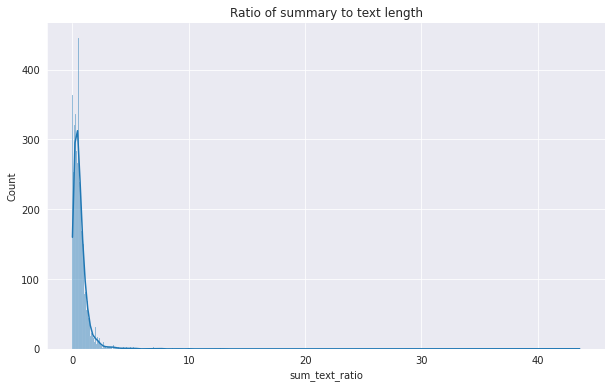

In [167]:
# lets see the graph again

sns.histplot(data['sum_text_ratio'], kde = True)
plt.title("Ratio of summary to text length")

In [168]:
# Such following examples cannot be summarized by just using the given text

# Text: 
# User: Pretty! 💙 @browsercompany <STRICT_LINK>
# Summary:
# User: I'm not sure if I'm the only one who's having this issue, but I'm having a problem with the browserco app. I can't get it to open. I've tried restarting my phone, restarting the app, and even restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting my phone and restarting the app and it still won't open. I've tried restarting m

# Text:
# User: @nick__pattison @figma That’s worrying.
# Summary:
# A user shared their DonorsChoose project for books about taking care of the Earth and suggested that students could use Figma's FigJam to collaborate on ideas and action plans based on their readings.

# Some summaries are not even related to the Text
# Text: 
# User: Why does @NotionHQ use a Somali domain?
# Summary:
# User is frustrated with the lack of updates on the Notion website and mentions that they have been waiting for a new feature for a long time.

# In some examples, the review doesn't look like it is of the mentioned product
# Text:
# User: Here’s an invite to Arc, the browser. Use it, you'll love it!
#arc @arcinternet <STRICT_LINK>
# Summary:
# User is excited about the new features in the latest version of Firefox, including the ability to create a new tab with a custom background and a new feature that allows users to create a new tab with a custom background and a new tab page.


# For a tweet to belong to the product, the product name has to be mentioned in the tweet. Or the mention (@). We can maybe check using this heuristic if the tweet even belongs to the product

# looking at some of the above texts, I believe the model will have less metric score on Twitter source.

In [65]:
# even while reading some G2 text and summary, they dont seem related to each other. 

# Text:
# User: I use Figjam to get alignment on key initiatives and work through brainstorming sessions.
# User: Easy to use and flexible for all my needs.
# User: Can be hard to give access to others and sometimes it doesnt work

# Summary:
# Users appreciate Miro's ability to facilitate synchronous and asynchronous brainstorming, as well as its wide range of templates for visualizing ideas and requirements. However, they note that it requires a good internet connection and lacks features like hatched backgrounds, compared to lighter tools like Excalidraw.

# There are many instances like above

# lets find the semantic similarity between the summary and text. 
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer(model_for_embeddings)

def get_sim_score(row):
    #Compute embedding for both lists
    embeddings1 = model.encode(row["Text"], convert_to_tensor=True)
    embeddings2 = model.encode(row["Summary"], convert_to_tensor=True)
    #Compute cosine-similarities
    cosine_score = util.cos_sim(embeddings1, embeddings2)
    return cosine_score.item()

In [170]:
data['sim_score'] = data.apply(get_sim_score, axis = 1)

In [64]:
sns.displot(data['sim_score'], kind = "hist")

KeyError: 'sim_score'

In [172]:
# some summaries look unrelated to the Text
data[(data['sim_score'] < 0.2) & (data['Summary'] != "Nothing") & (data['text_length'] > 4)]

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score
239,Notion,Appstore/Playstore,User: Where is the Arabic language thanks,Product: Notion\nFeedbacktype: RecordTypeRevie...,7,15,2.142857,0.137244
998,Notion,Twitter,User: We're excited to announce you can now wo...,User is excited about the new Notion for Teams...,44,51,1.159091,0.087017
1000,Notion,Twitter,"User: 1/ As a virtual assistant, using the rig...",User is excited about the new features in Not...,197,67,0.340102,0.189642
1019,Notion,Twitter,User: Now have a second monitor that does noth...,User is using Notion for their personal proje...,61,27,0.442623,0.123163
1031,Notion,Twitter,User: How do you stay motivated when working o...,User is excited about the new features in Noti...,77,16,0.207792,0.197318
...,...,...,...,...,...,...,...,...
4136,figma,G2,User: It helps mainly with the planning of lea...,Users appreciate Figma for its ease in helping...,51,32,0.627451,0.180423
4210,figma,G2,User: We work in a way that encourages loads o...,Users appreciate Figma for its collaboration t...,128,46,0.359375,0.172062
4328,figma,G2,User: Prototyping. Allows me to visualize how ...,Users appreciate Miro for its ability to strea...,108,55,0.509259,0.170162
4337,figma,G2,User: We could visualize an app design on the ...,Users prefer Miro over Figma for quickly creat...,86,40,0.465116,0.108902


In [173]:
# get indices with low sim score. 0.2 is just a parameter. Sometimes text says: "Great app" and the summary is a bit large, and sim_score gets low value. To avoid such indices in exploration, we keep text_length > 4
less_sim_scores_indices = data[(data['sim_score'] < 0.2) & (data['Summary'] != "Nothing") & (data['text_length'] > 4)].index

In [174]:
print((list(less_sim_scores_indices)))
# manually looked into these samples. They summary and text really dont make sense. Will remove such indices from training set. Will keep in test set, but will calculate metrics separately for a range of sim_scores

[239, 998, 1000, 1019, 1031, 1039, 1045, 1046, 1047, 1049, 1050, 1051, 1058, 1079, 1080, 1088, 1117, 1138, 1145, 1162, 1165, 1174, 1189, 1191, 1196, 1198, 1199, 1210, 1231, 1232, 1245, 1250, 1253, 1256, 1258, 1261, 1273, 1279, 1283, 1288, 1290, 1306, 1311, 1333, 1344, 1361, 1370, 1374, 1377, 1392, 1394, 1400, 1401, 1405, 1408, 1409, 1412, 1414, 1415, 1416, 1417, 1420, 1426, 1434, 1437, 1447, 1448, 1494, 1502, 1507, 1516, 1521, 1534, 1539, 1540, 1543, 1547, 1548, 1561, 1616, 1619, 1627, 1652, 1683, 1690, 1691, 1692, 1693, 1697, 1725, 1732, 1738, 1751, 1760, 1766, 1771, 1778, 1789, 1792, 1795, 1800, 1804, 1809, 1810, 1816, 1842, 1859, 1860, 1863, 1871, 1894, 1898, 1900, 1904, 1905, 1907, 1911, 1912, 1918, 1921, 1922, 1937, 1938, 1939, 1961, 1977, 2024, 2039, 2047, 2064, 2070, 2082, 2089, 2092, 2094, 2108, 2109, 2111, 2115, 2122, 2131, 2132, 2134, 2138, 2141, 2143, 2155, 2158, 2159, 2167, 2168, 2173, 2177, 2183, 2184, 2188, 2196, 2201, 2202, 2204, 2207, 2216, 2221, 2230, 2232, 2237, 2239,

In [175]:
data.isna().sum()

Customer          0
Type              0
Text              0
Summary           0
text_length       0
summary_length    0
sum_text_ratio    0
sim_score         0
dtype: int64

In [176]:
# when saving, "None" becomes Null
# data['Summary'] = data['Summary'].apply(lambda summary: "Nothing" if summary == "None" else summary)

In [177]:
# split the dataset. There is no label or group to perform groupwise or stratified splitting. We could do stratified splitting based on binning of sim_score, but it won't matter much. So perform Random splitting

# shuffle the dataset
shuffled_data = data.sample(frac = 1, random_state=42).reset_index(drop = True)

shuffled_data['Text'] = shuffled_data['Text'].replace("NA", pd.NA)
shuffled_data['Text'] = shuffled_data['Text'].replace("", pd.NA)
shuffled_data = shuffled_data[shuffled_data['Text'].notnull()].reset_index(drop = True)

print(shuffled_data.shape)
shuffled_data.to_csv("common_shuffled_data.csv")

(4816, 8)


In [178]:
# take care of different language 
# run similarity to find most matching summary and text

#Eg: User noticed that the FigJam marker looks thick when changing its size and suggested that the nib should get less pointy.  ---> 410 Summary
# Just noticed that that FigJam marker be lookin thicc when you change its size  cc figma 
# miggi figma But but But the nib should get less pointy ---> 3311 Text match with each other
# from datasets import Dataset
# import datasets

# dataset = datasets.load_dataset("csv", data_files="data_v1.csv")['train']
# print(dataset.column_names)
# embeddings_dataset.add_faiss_index(column="Text")

In [179]:

dataset = Dataset.from_pandas(shuffled_data)

In [180]:
model = SentenceTransformer(model_for_embeddings)

In [181]:
embeddings_dataset = dataset.map(
    lambda x: {"embeddings_text": model.encode(x["Text"])}
)

Map:   0%|          | 0/4816 [00:00<?, ? examples/s]

In [182]:
embeddings_dataset = embeddings_dataset.map(
    lambda x: {"embeddings_summary": model.encode(x["Summary"])}
)

Map:   0%|          | 0/4816 [00:00<?, ? examples/s]

In [183]:
import numpy as np

embeddings_dataset = embeddings_dataset.with_format("np")


In [184]:
embeddings_dataset = embeddings_dataset.map(lambda row: {"embeddings_text": row['embeddings_text'].reshape(-1)})
embeddings_dataset = embeddings_dataset.map(lambda row: {"embeddings_summary": row['embeddings_summary'].reshape(-1)})

Map:   0%|          | 0/4816 [00:00<?, ? examples/s]

Map:   0%|          | 0/4816 [00:00<?, ? examples/s]

#### Now we will try to index summary instead of text and for each text try to find the nearest neighbor. This is done because this is many to one problem

In [185]:
# this is for indexing summary
embeddings_dataset.add_faiss_index(column="embeddings_summary")

  0%|          | 0/5 [00:00<?, ?it/s]

Dataset({
    features: ['Customer', 'Type', 'Text', 'Summary', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score', 'embeddings_text', 'embeddings_summary'],
    num_rows: 4816
})

In [186]:
data_with_NN = []
for idx, row in enumerate(embeddings_dataset):
    score, sample = embeddings_dataset.get_nearest_examples(
        "embeddings_summary", row['embeddings_text'], k=1
    )
    sample['current_summary'] = [row['Summary']]
    sample['current_text'] = [row['Text']]
    sample['new_sim_score'] = score
    data_with_NN.append(sample)

In [187]:
df_with_NN = pd.DataFrame(data_with_NN)

In [188]:
def get_item_from_list(row):
    for feat in row.keys():
        row[feat] = list(row[feat])[0]
    return row

In [189]:
df_with_NN = df_with_NN.apply(get_item_from_list)

In [191]:
df_with_NN.head()

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,current_summary,current_text,new_sim_score
0,Notion,Twitter,User: If anyone wants to test out the new Arc ...,User is excited about the new features in the ...,94,55,0.585106,0.341743,"[-0.07999487, -0.10687993, 0.06315385, 0.02471...","[-0.018290058, -0.12421812, -0.004275959, -0.0...",Nothing,User: Wow! now on #Arc Control + Tab or ` to c...,0.767929
1,figma,Twitter,User: A free course by @Figma to help you get ...,A user shared their daily tech stack for their...,20,40,2.0,0.252479,"[0.006553283, 0.032159187, -0.020382259, -0.03...","[-0.08829945, -0.05147805, 0.046722118, -0.038...",User is excited about the new features in Noti...,User: Tools I use daily:\n✔️@clickup\n✔️@tabni...,0.828977
2,Notion,Appstore/Playstore,User: I thought I'd try it because they said i...,User finds the product difficult to use and st...,21,12,0.571429,0.63352,"[-0.090007834, -0.05653018, -0.044100218, -0.0...","[0.008592834, -0.00027826338, -0.03140914, -0....",User finds Zoom easy to access.,User: easy to access,0.825272
3,Notion,Twitter,User: post your @arcinternet sidebar pins <STR...,User is frustrated with the lack of updates on...,32,26,0.8125,0.122787,"[-0.013209798, -0.10474234, 0.021447707, 0.110...","[-0.007269946, 0.017088275, 0.038596455, -0.02...",Nothing,User: When will it be? It's already the third ...,1.207052
4,Notion,Appstore/Playstore,User: I love notion with all of my heart becau...,User loves Notion but is upset because it logg...,51,26,0.509804,0.795327,"[-0.0033459903, 0.00077141664, 0.0015550139, -...","[0.02208034, 0.014082821, -0.009182252, -0.034...",Nothing,User: I HAD SUCH A LONG NOTION PAGES AND MY AC...,0.957553


In [199]:
# # save the matched data obtained after ANN for faster loading


# dataset = Dataset.from_pandas(df_with_NN)

# ds = datasets.DatasetDict()

# ds['train'] = dataset

# print(ds)

# ds.save_to_disk("common_ann_data")
# dataset.to_csv("common_ann_data.csv")

DatasetDict({
    train: Dataset({
        features: ['Customer', 'Type', 'Text', 'Summary', 'text_length', 'summary_length', 'sum_text_ratio', 'sim_score', 'embeddings_text', 'embeddings_summary', 'current_summary', 'current_text', 'new_sim_score'],
        num_rows: 4816
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/4816 [00:00<?, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

65280817

In [196]:
# import datasets
# from datasets import Dataset

# embeddings_dataset = datasets.load_from_disk("common_ann_data")['train']

In [3]:
# df_with_NN = pd.read_csv("common_ann_data.csv")
# df_with_NN.head()

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,current_summary,current_text,new_sim_score
0,Notion,Twitter,User: If anyone wants to test out the new Arc ...,User is excited about the new features in the ...,94,55,0.585106,0.341743,[-7.99948722e-02 -1.06879927e-01 6.31538481e-...,[-1.82900578e-02 -1.24218121e-01 -4.27595899e-...,Nothing,User: Wow! now on #Arc Control + Tab or ` to c...,0.767929
1,figma,Twitter,User: A free course by @Figma to help you get ...,A user shared their daily tech stack for their...,20,40,2.000000,0.252479,[ 6.55328296e-03 3.21591869e-02 -2.03822590e-...,[-8.82994533e-02 -5.14780506e-02 4.67221178e-...,User is excited about the new features in Noti...,User: Tools I use daily:\n✔️@clickup\n✔️@tabni...,0.828977
2,Notion,Appstore/Playstore,User: I thought I'd try it because they said i...,User finds the product difficult to use and st...,21,12,0.571429,0.633520,[-9.00078341e-02 -5.65301813e-02 -4.41002175e-...,[ 8.59283376e-03 -2.78263382e-04 -3.14091407e-...,User finds Zoom easy to access.,User: easy to access,0.825272
3,Notion,Twitter,User: post your @arcinternet sidebar pins <STR...,User is frustrated with the lack of updates on...,32,26,0.812500,0.122787,[-1.32097984e-02 -1.04742341e-01 2.14477070e-...,[-7.26994593e-03 1.70882754e-02 3.85964550e-...,Nothing,User: When will it be? It's already the third ...,1.207052
4,Notion,Appstore/Playstore,User: I love notion with all of my heart becau...,User loves Notion but is upset because it logg...,51,26,0.509804,0.795327,[-3.34599032e-03 7.71416642e-04 1.55501394e-...,[ 2.20803395e-02 1.40828211e-02 -9.18225199e-...,Nothing,User: I HAD SUCH A LONG NOTION PAGES AND MY AC...,0.957553


In [4]:
df_with_NN[df_with_NN['current_summary'] == "Nothing"].sample(5)

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,current_summary,current_text,new_sim_score
1960,Notion,Appstore/Playstore,User: Не работает.,User is experiencing issues with the product.,3,7,2.333333,0.322746,[ 4.17586751e-02 8.86843875e-02 -5.82976602e-...,[ 2.06520762e-02 1.83819905e-02 -2.24867184e-...,Nothing,User: Bad,0.995520
1336,Notion,Appstore/Playstore,"User: I stopped at the tutorial, please improv...",User suggests improving the tutorial as soon a...,12,9,0.750000,0.807828,[-3.12997177e-02 8.24957117e-02 -2.18609311e-...,[-5.31895757e-02 7.60235079e-03 -1.53233269e-...,Nothing,User: Good luck on,1.244186
2572,Notion,Appstore/Playstore,User: One of my favorite apps. Absolutely esse...,User praises the app as one of their favorite ...,14,15,1.071428,0.772849,[-8.44001248e-02 3.59966457e-02 5.70954289e-...,[-9.11614522e-02 7.65861347e-02 1.12448856e-...,Nothing,User: Nice apps 👌,0.734007
2346,Notion,Appstore/Playstore,User: This app is amazing. I paid for the subs...,User is unhappy with the AI not working and ha...,26,19,0.730769,0.778491,[-6.60805404e-02 -7.09946454e-02 4.81287315e-...,[-2.47891117e-02 -1.90002806e-02 2.87371110e-...,Nothing,User: I feel better now,1.249208
4141,figma,Twitter,User: Tutorial Thread ✨\nLearn how to create t...,Users are discussing the possibility of export...,94,20,0.212766,0.253172,[-9.90078896e-02 3.56497318e-02 6.02212595e-...,[-7.06543624e-02 -1.61396842e-02 -1.22278715e-...,Nothing,User: 🔴 L i v e\nWow?\nCan we export animation...,0.359330


In [5]:
# logic to select either the Summary or current_summary

df_with_NN['current_text_length'] = df_with_NN['current_text'].apply(lambda text: len(text.split()))

In [6]:
df_with_NN[(df_with_NN['current_summary'] == "Nothing") & (df_with_NN['current_text_length'] < 4)].sample(5)

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,current_summary,current_text,new_sim_score,current_text_length
334,Notion,Twitter,User: I've been using @browsercompany's ARC br...,User is using the browser for their work and i...,78,13,0.166667,0.478067,[-1.62448455e-02 -6.66054860e-02 7.43599609e-...,[-3.06039564e-02 5.91402911e-02 -3.59613150e-...,Nothing,User: 👍,1.171561,2
564,Notion,Twitter,User: I just ordered a MacBook🫣\nWhat apps sho...,User is using a MacBook and is looking for app...,33,14,0.424242,0.529052,[-1.98664684e-02 -9.33718979e-02 3.36872116e-...,[-4.65946971e-03 -2.06733327e-02 -1.68193467e-...,Nothing,User: Nich app,1.067546,3
639,zoom,Appstore/Playstore,User: It is useful,User finds Zoom useful.,4,4,1.000000,0.510501,[-3.98554057e-02 6.75937906e-02 -5.61882034e-...,[-2.27500545e-03 2.82495916e-02 -6.07798994e-...,Nothing,User: Zoom,0.290845,2
3392,Notion,Twitter,User: Less than 500 followers and looking for ...,User is a teacher and uses Notion to create i...,79,25,0.316456,0.266407,[ 4.33756672e-02 -1.50802866e-01 -1.57576017e-...,[-5.05233817e-02 1.19767003e-02 -7.03265667e-...,Nothing,User: Good.,1.224903,2
4668,Notion,Twitter,User: This week's @NotionHQ content is brought...,User shares a link to a Notion article about t...,12,28,2.333333,0.274184,[-2.87289433e-02 3.52558792e-02 -5.83249656e-...,[-3.76015678e-02 -2.37714853e-02 -1.92564055e-...,Nothing,User: Very bed,1.313522,3


In [7]:
# logic to take Sumamry or current_summary.
# if current_text_length < 4 and current_summary == Nothing, then take current summary
# else take Summary

for idx, row in df_with_NN.iterrows():
    if row['current_text_length'] < 4 and row['current_summary'] == "Nothing":
        df_with_NN.loc[idx, "Summary"] = "Nothing"
    

In [8]:
df_with_NN[(df_with_NN['current_summary'] == "Nothing") & (df_with_NN['current_text_length'] < 4)].sample(5)

,Customer,Type,Text,Summary,text_length,summary_length,sum_text_ratio,sim_score,embeddings_text,embeddings_summary,current_summary,current_text,new_sim_score,current_text_length
754,Notion,Twitter,User: Less than 500 followers and looking for ...,Nothing,79,25,0.316456,0.266407,[ 4.33756672e-02 -1.50802866e-01 -1.57576017e-...,[-5.05233817e-02 1.19767003e-02 -7.03265667e-...,Nothing,User: That's great.,1.089830,3
3266,figma,Twitter,"User: Okay, devs... how many tabs do you curre...",Nothing,42,22,0.523810,0.217675,[ 7.53271058e-02 -4.93078306e-02 2.59005185e-...,[-8.60133693e-02 1.11826388e-02 2.75853910e-...,Nothing,User: Awesome 👍🏻👍🏻,1.186399,3
2409,Notion,Twitter,User: I've been using @browsercompany's ARC br...,Nothing,78,13,0.166667,0.478067,[-1.62448455e-02 -6.66054860e-02 7.43599609e-...,[-3.06039564e-02 5.91402911e-02 -3.59613150e-...,Nothing,User: Ft,1.105088,2
4610,Notion,Twitter,User: Less than 500 followers and looking for ...,Nothing,79,25,0.316456,0.266407,[ 4.33756672e-02 -1.50802866e-01 -1.57576017e-...,[-5.05233817e-02 1.19767003e-02 -7.03265667e-...,Nothing,User: Great 🙏,1.177367,3
3089,Notion,Twitter,User: Less than 500 followers and looking for ...,Nothing,79,25,0.316456,0.266407,[ 4.33756672e-02 -1.50802866e-01 -1.57576017e-...,[-5.05233817e-02 1.19767003e-02 -7.03265667e-...,Nothing,User: Study,0.770748,2


In [9]:
df_with_NN = df_with_NN[["Customer", "Type", "Text", "Summary"]]

In [213]:
len(df_with_NN)

4816

In [11]:
df_with_NN['sim_score'] = df_with_NN.apply(get_sim_score, axis = 1)

In [14]:
df_with_NN.to_csv("common_ann_data_summary_matched_sim_scores.csv", index = False)

In [34]:
data = pd.read_csv("common_ann_data_summary_matched_sim_scores.csv")
data.head()

,Customer,Type,Text,Summary,sim_score
0,Notion,Twitter,User: If anyone wants to test out the new Arc ...,User is excited about the new features in the ...,0.341743
1,figma,Twitter,User: A free course by @Figma to help you get ...,A user shared their daily tech stack for their...,0.252479
2,Notion,Appstore/Playstore,User: I thought I'd try it because they said i...,User finds the product difficult to use and st...,0.633520
3,Notion,Twitter,User: post your @arcinternet sidebar pins <STR...,User is frustrated with the lack of updates on...,0.122787
4,Notion,Appstore/Playstore,User: I love notion with all of my heart becau...,User loves Notion but is upset because it logg...,0.795327


In [35]:
# preprocess text to remove strict_links and emojis. 
# Don't remove @ and # because the user might have tweeted as: Good feature by @Enterpret, @Notion always crash. Here without mentions, it would be impossible to know the good review is for which product and the bad review for which
# Dont remove hastag because some people tweet: #excited #lovedit etc. which can help know the intent of review

def preprocess_text(text):

    # Remove strict links
    text = re.sub(r'https?:\/\/\S+', '', text)

    # Remove emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251" 
        "]+"
    )
    text = emoji_pattern.sub('', text)

    # Remove any remaining special characters or punctuations
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace("STRICT_LINK", "")

    return text


# apply on Text
if PREPROCESS:

    example = data[data['Type'] == "Twitter"]['Text'][997]
    processed_text = preprocess_text(example)
    print("Original text: ", example)
    print("Processed text: ", processed_text)
    data['Text'] = data['Text'].apply(preprocess_text)

In [36]:
# All Text start with User. I think it is redundant. Lets remove it

# // Need to extract only summary from such examples. 
# // Summary is irrelevant to the Text
# Text: User: Where is the Arabic language thanks 
# Summary:  
# Product: Notion
# Feedbacktype: RecordTypeReview
# Review Content: User: I love it
# Summary:
# User loves the product.


if PREPROCESS:
    data['Text'] = data['Text'].apply(lambda text: text.replace("User ", "").strip())
    data['Text'] = data['Text'].apply(lambda text: text.replace("User: ", "").strip())
    data['Summary'] = data['Summary'].apply(lambda summary: summary.split("Summary:")[-1])

    # thus successfully extracted the summary
    print(data[data['Summary'].str.contains("Summary:")])  

In [37]:
len(data)

4816

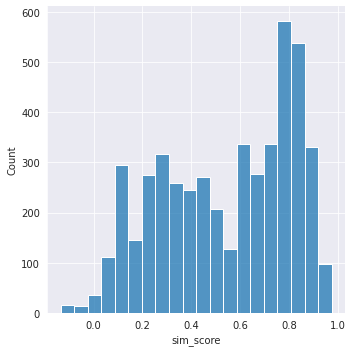

In [38]:
# looks better than before
sns.displot(data['sim_score'])

In [39]:
# creating Dataset 
# make 70-10-20 split for train/val/test
train_size = int(len(data) * 0.7)
val_end_index = int(len(data) * 0.8)
train_data = data.loc[:train_size, :]
val_data = data.loc[train_size:val_end_index :]
test_data = data.loc[val_end_index: , :]

train_data['split'] = "train"
val_data['split'] = "val"
test_data['split'] = "test"
data = pd.concat([train_data, val_data, test_data])
data.to_csv(DATA_SAVE_NAME + ".csv")
print(len(train_data), len(val_data), len(test_data))

trainds = Dataset.from_pandas(train_data)
valds = Dataset.from_pandas(val_data)
testds = Dataset.from_pandas(test_data)

ds = DatasetDict()

ds['train'] = trainds
ds['val'] = valds
ds['test'] = testds

print(ds)

ds.save_to_disk(DATA_SAVE_NAME)

3372 482 964
DatasetDict({
    train: Dataset({
        features: ['Customer', 'Type', 'Text', 'Summary', 'sim_score', 'split'],
        num_rows: 3372
    })
    val: Dataset({
        features: ['Customer', 'Type', 'Text', 'Summary', 'sim_score', 'split'],
        num_rows: 482
    })
    test: Dataset({
        features: ['Customer', 'Type', 'Text', 'Summary', 'sim_score', 'split'],
        num_rows: 964
    })
})


/tmp/ipykernel_3830/1012357572.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['split'] = "train"
/tmp/ipykernel_3830/1012357572.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['split'] = "val"
/tmp/ipykernel_3830/1012357572.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Saving the dataset (0/1 shards):   0%|          | 0/3372 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/482 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/964 [00:00<?, ? examples/s]

In [141]:
train_data.head()

,Text,Summary,Customer,Type,text_length,summary_length,sum_text_ratio,sim_score
0,If anyone wants to test out the new Arc browse...,"User is excited about the new browser CO, and...",Notion,Twitter,69,19,0.275362,0.572584
1,I used it well on my laptop but on the iPad wh...,User is enjoying the app but is unable to use ...,Notion,Twitter,61,22,0.360656,0.629355
2,Love it,User is excited about their design being featu...,figma,Twitter,2,22,11.000000,0.315750
3,Not userfriendly at all,User finds the app cluttered and difficult to ...,Notion,Appstore/Playstore,4,16,4.000000,0.383614
4,Its the same right Just relax,User is experiencing discomfort after using No...,Notion,Appstore/Playstore,6,14,2.333333,0.239591


In [142]:
val_data.head()

,Text,Summary,Customer,Type,text_length,summary_length,sum_text_ratio,sim_score
3327,Look what i got this morning browsercompany,User is excited about the new browser from Bro...,Notion,Twitter,7,15,2.142857,0.559252
3328,We needed a tool to effectively whiteboard rem...,The user finds Miro effective for remote white...,figma,G2,86,30,0.348837,0.740227
3329,The last update couldnt fix the problem I can ...,User experiences issues with loading pages aft...,Notion,Appstore/Playstore,17,10,0.588235,0.591285
3330,When I search I feel that its intuitive to ret...,The user suggests adding a button to stay and ...,figma,Twitter,42,26,0.619048,0.786500
3331,No one throws a design party like davidhoang \...,User enjoyed the ReplitDesign Happy Hour hoste...,figma,Twitter,37,28,0.756757,0.761902


In [143]:
test_data.head()

,Text,Summary,Customer,Type,text_length,summary_length,sum_text_ratio,sim_score
3803,Im sorry I missed,"User lost all their diary, photos, and preciou...",Notion,Appstore/Playstore,4,33,8.250000,0.281010
3804,Nine,Nothing,Notion,Appstore/Playstore,1,1,1.000000,0.276169
3805,My notion is just showing please connect to th...,User experiences an issue with the application...,Notion,Appstore/Playstore,39,23,0.589744,0.610186
3806,TFW you are tired of remembering passwords so ...,User created a kanban board in Figma to track ...,figma,Twitter,20,17,0.850000,0.905597
3807,It is great for collaboration and makes remote...,The product is helping the User to collaborate...,figma,G2,96,67,0.697917,0.879357
